In [1]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

import torch
from exp.loaddata_utils import ImageNetLoadClass
import exp.utils_visualise as utils_visualise
from torch.autograd import Variable
import matplotlib.pyplot as plt

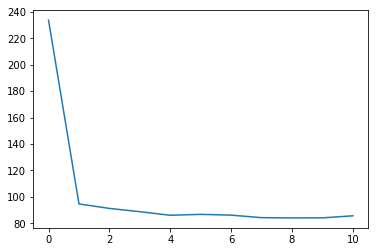

In [2]:
loss = torch.load('../checkpts/1017-vae-mnist_lr_0.001.loss')
plt.plot(range(len(loss)), [loss[i] for i in xrange(len(loss))])
plt.show()

### Test the model

Here I will take some training imagenet images randomly and see how the result goes.
Because my training set is randomly subset of 1/10 of original training sets. I am not sure now the images I take is actually not be seen or seen before. But let's do some sanity check!

Let's corrupt the images! I would try different corruptions.  
Let's try defining some functions here.

In [3]:
import numpy as np
def random_quarter_corrupt(length=None):
    def tmp(images, length=length):
        clone_images = images.clone()
        _, _, H, W = images.size()
        if length is None:
            length = H / 2
        
        mask = torch.ones(images.size(0), 1, images.size(2), images.size(3))
        
        pos1 = np.random.randint(0, W/2.)
        pos2 = np.random.randint(0, W/2.)
        
        mask[:, :, pos1:pos1+length, pos2:pos2+length] = 0.
        return clone_images * mask, mask
    return tmp

def random_corrupt(prob=0.5):
    def tmp (images):
        clone_images = images.clone()

        mask = torch.bernoulli(torch.FloatTensor(images.size(0), 1, images.size(2), images.size(3)).fill_(prob))
        return clone_images * mask, mask
    return tmp

def corrupt_and_show(images, corrupt_func, generative_model, num_samples=1):
    corrupted_imgs, mask = corrupt_func(images)
    
    arr = []
    for i in xrange(num_samples):
        restored = generative_model.generate_images(images, mask)

        expand_mask = mask.expand_as(restored)

        restored[expand_mask == 1.] = images[expand_mask == 1.]
        arr.append(restored)
    
    fig, ax = plt.subplots(figsize=(20,10))
    utils_visualise.save_figs(corrupted_imgs, '', 
                              nrow=5, visualize=True, ax=ax)
    plt.show()
    plt.close()
    for i in xrange(num_samples):
        fig2, ax2 = plt.subplots(figsize=(20,10))
        utils_visualise.save_figs(arr[i], '', nrow=5, visualize=True, ax = ax2)
        plt.show()
        plt.close()

First, we load some imagenet images.

In [4]:
from exp.loaddata_utils import load_mnist_keras_loader
train_loader, test_loader = load_mnist_keras_loader(batch_size=10, cuda=False)

images, _ = iter(test_loader).next()
print images.size()

Using Theano backend.


torch.Size([10, 1, 28, 28])


## load the VAE model

In [5]:
from arch.Inpainting.VAE_InpaintingMnist import VAE_InpaintingMnist

generative_model2 = VAE_InpaintingMnist()
states = torch.load('../checkpts/1017-vae-mnist_lr_0.001_epochs_10',
                    map_location=lambda storage, loc: storage)
generative_model2.load_state_dict(states['state_dict'])
generative_model2.eval()

print 'Load generative model'

num_training: 50000
Load generative model


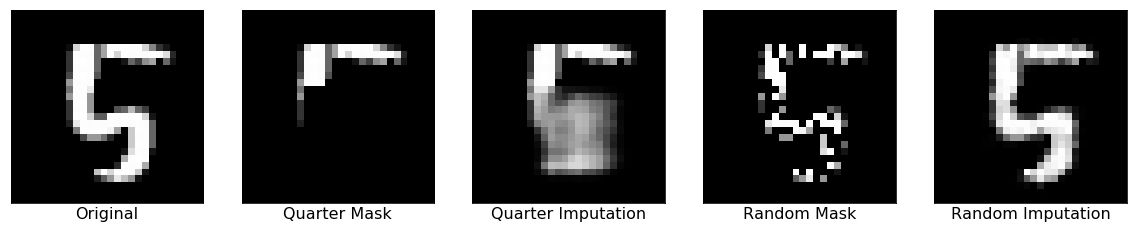

In [24]:
corrupted_imgs_quarter, mask_quarter = random_quarter_corrupt()(images[0:1])
corrupted_imgs_random, mask_random = random_corrupt()(images[0:1])

restored_quarter = generative_model2.impute_missing_imgs(corrupted_imgs_quarter, mask_quarter)
restored_random = generative_model2.impute_missing_imgs(corrupted_imgs_random, mask_random)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

utils_visualise.plot_pytorch_img(images[0].expand(3, 28, 28), axes[0])
utils_visualise.plot_pytorch_img(corrupted_imgs_quarter[0].expand(3, 28, 28), axes[1])
utils_visualise.plot_pytorch_img(restored_quarter[0].expand(3, 28, 28), axes[2])
utils_visualise.plot_pytorch_img(corrupted_imgs_random[0].expand(3, 28, 28), axes[3])
utils_visualise.plot_pytorch_img(restored_random[0].expand(3, 28, 28), axes[4])

axes[0].set_xlabel('Original', fontsize=16)
axes[1].set_xlabel('Quarter Mask', fontsize=16)
axes[2].set_xlabel('Quarter Imputation', fontsize=16)
axes[3].set_xlabel('Random Mask', fontsize=16)
axes[4].set_xlabel('Random Imputation', fontsize=16)

for ax in axes:
    ax.set_xticks([], [])
    ax.set_yticks([], [])

fig.savefig('vae_generation.eps', format='eps', dpi=200, bbox_inches='tight')

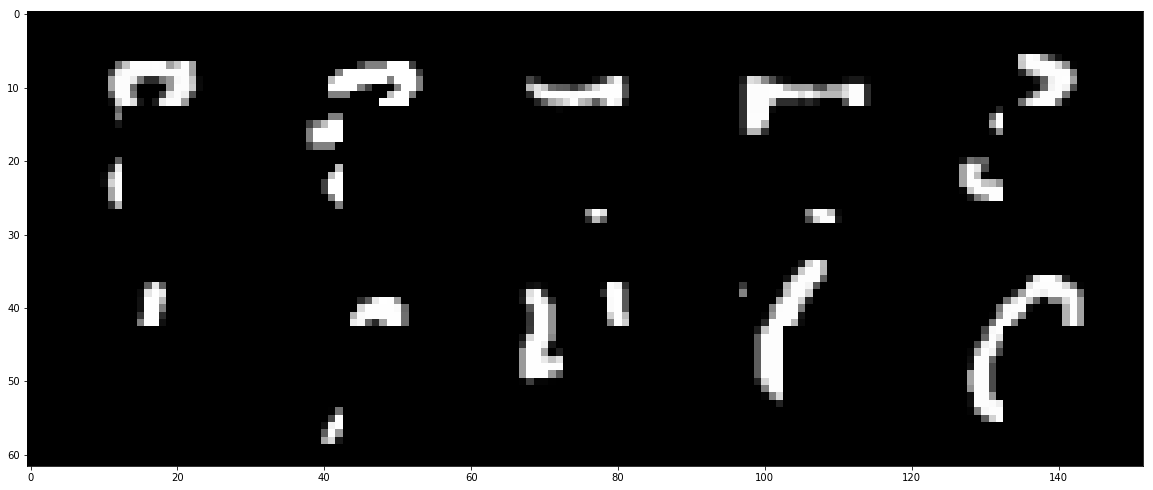

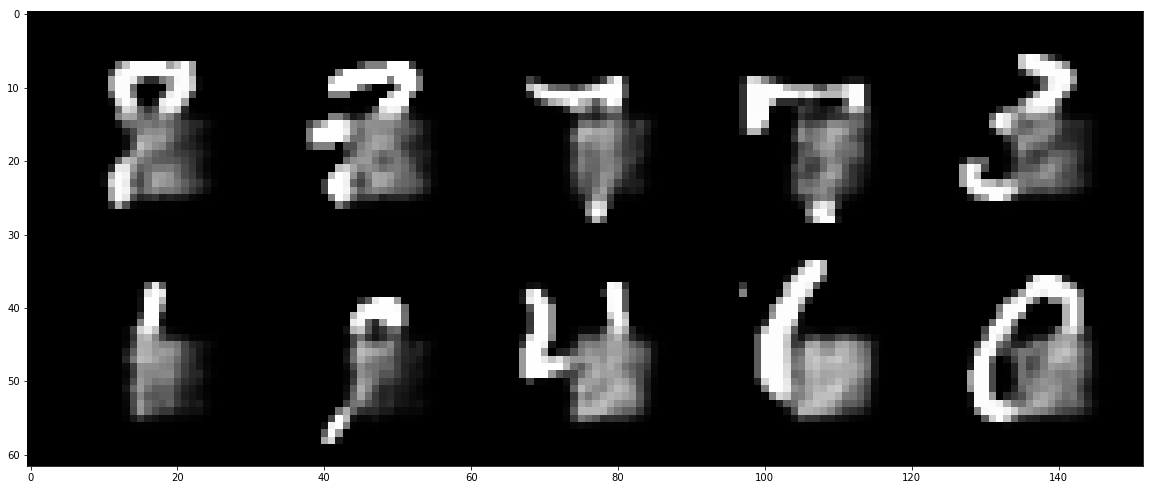

In [15]:
corrupt_and_show(images, corrupt_func=random_quarter_corrupt(), generative_model=generative_model2, num_samples=1)

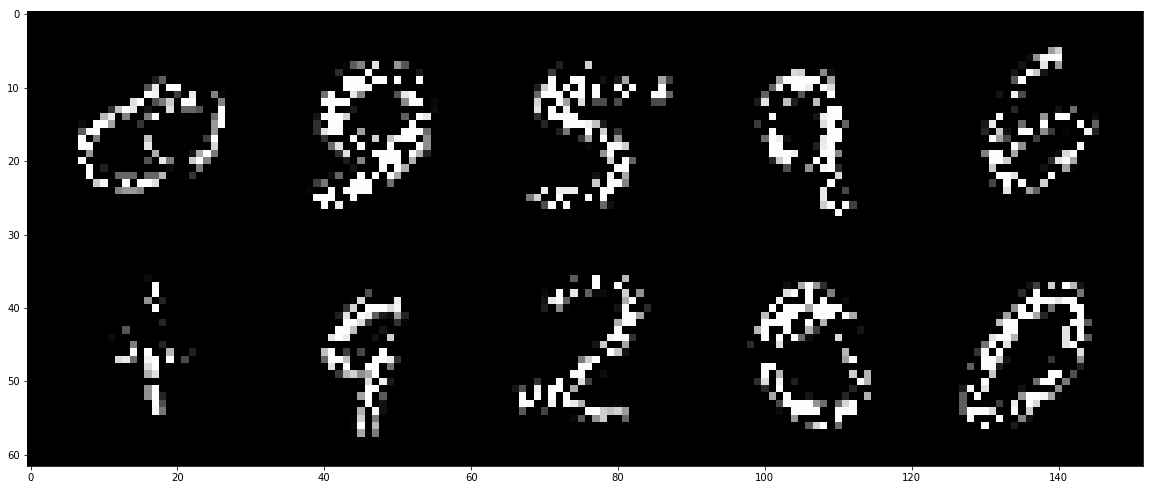

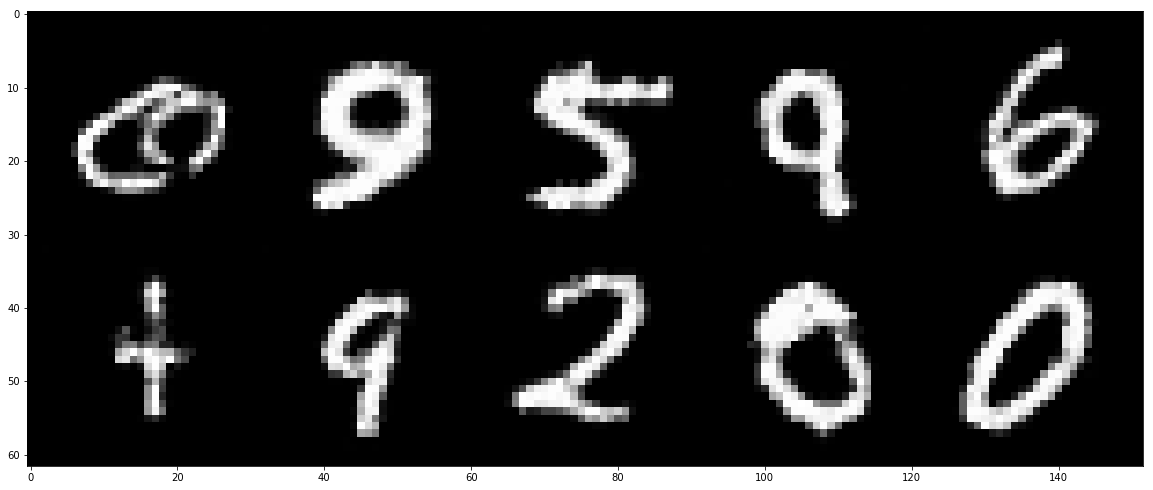

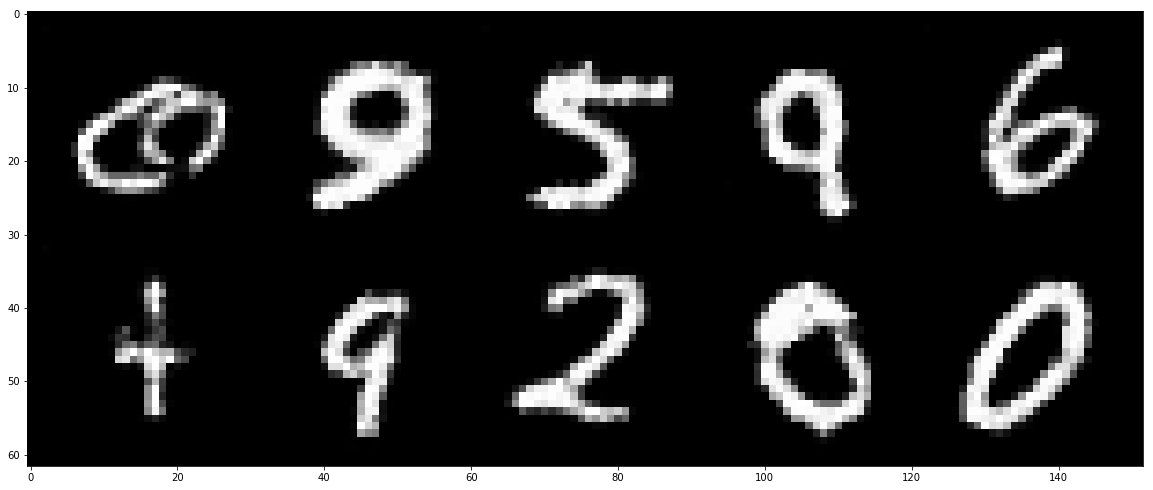

In [8]:
corrupt_and_show(images, corrupt_func=random_corrupt(0.5), generative_model=generative_model2, num_samples=2)